In [65]:
!pip install install-jdk
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

## install Java


In [101]:

import jdk
download_url = jdk.get_download_url('8')
print(download_url)  
try:
    jdk.install('8', jre=True)
except PermissionError:
    print("Java already installed!")

https://api.adoptopenjdk.net/v3/binary/latest/8/ga/linux/x64/jdk/hotspot/normal/adoptopenjdk
Java already installed!


In [102]:
import os
java_path = '/home/jupyter/.jre/jdk8u262-b10-jre'
os.environ['JAVA_HOME'] = java_path


## Import Dependencies

In [103]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
%matplotlib inline

# Import Data

In [165]:
# wash data
var_y = pd.read_csv("washdata.csv") 
var_y = var_y[var_y['STATION_NUMBER'] == 6201]
var_y = var_y[['Date','TransactionCount']]
var_y.rename(columns={'Date': 'data', 'TransactionCount': 'transactions'}, inplace=True)
var_y = var_y.groupby("data")["transactions"].sum().fillna(0)
var_y = var_y.iloc[14:]
var_y.to_csv (r'test.csv', index = True, header=True)
var_y.to_csv (r'data/var_y.csv', index = True, header=True)

# Temperature
var_x = pd.read_csv("weather_daily.csv") 
var_x = var_x[['date','avgTemp']]
var_x.rename(columns={'date': 'data', 'avgTemp': 'temp'}, inplace=True)
var_x.to_csv (r'data/var_x.csv', index = False, header=True)

# Rain
var_z = pd.read_csv("weather_daily.csv") 
var_z = var_z[['date','rainAmount']]
var_z.rename(columns={'date': 'data', 'rainAmount': 'rain'}, inplace=True)
var_z.to_csv (r'data/var_z.csv', index = False, header=True)

# Weekday
weekday = pd.read_csv("weather_with_features.csv") 
weekday = weekday[['date','weekday']]
weekday.rename(columns={'date': 'data', 'weekday': 'weekday'}, inplace=True)
weekday.to_csv (r'data/weekday.csv', index = False, header=True)

# Month
month = pd.read_csv("weather_with_features.csv") 
month = month[['date','month']]
month.rename(columns={'date': 'data', 'month': 'month'}, inplace=True)
month.to_csv (r'data/month.csv', index = False, header=True)

# hasRained
hasRained = pd.read_csv("weather_with_features.csv") 
hasRained = hasRained[['date','hasRained']]
hasRained.rename(columns={'date': 'data', 'hasRained': 'hasRained'}, inplace=True)
hasRained.to_csv (r'data/hasRained.csv', index = False, header=True)

# clouds
avgCloudiness = pd.read_csv("weather_with_features.csv") 
avgCloudiness = avgCloudiness[['date','avgCloudiness']]
avgCloudiness.rename(columns={'date': 'data', 'avgCloudiness': 'avgCloudiness'}, inplace=True)
avgCloudiness.to_csv (r'data/avgCloudiness.csv', index = False, header=True)

dataset_x = pd.read_csv('data/var_x.csv', header=0, index_col=0)
dataset_y = pd.read_csv('data/var_y.csv', header=0, index_col=0)
dataset_z = pd.read_csv('data/var_z.csv', header=0, index_col=0)
weekday = pd.read_csv('data/weekday.csv', header=0, index_col=0)
month = pd.read_csv('data/month.csv', header=0, index_col=0)
hasRained = pd.read_csv('data/hasRained.csv', header=0, index_col=0)
avgCloudiness = pd.read_csv('data/avgCloudiness.csv', header=0, index_col=0)

df = pd.concat([dataset_y,dataset_x,dataset_z,weekday,month,hasRained,avgCloudiness], axis=1)
values = df.values
df.head()

# Dropping last two rows as no data for dataset y
df.drop(df.tail(2).index,inplace=True)

In [166]:
print('number of rows = ', df.shape[0])

number of rows =  233


## Plot the data
- for this step, we'll use the same code used here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

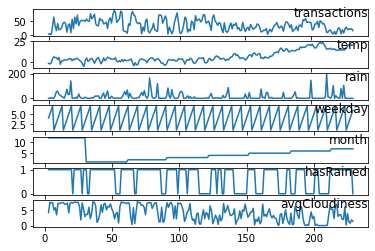

In [167]:
# specify columns to plot
values = df.values
groups = [0, 1, 2, 3,4,5,6]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Initialize h2o session

In [168]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 37 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_jupyter_i9lgpr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.059 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


## accessing H2OFlow UI
- by default H2OFlow UI will open on localhost port 54321
- accessing this UI is optional
- for more information on H2OFlow: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/flow.html

In [169]:
!npm install -g localtunnel -qq > /dev/null
get_ipython().system_raw('lt --port 54321 >> url.txt 2>&1 &')

[############......] / refresh-package-json:localtunnel: timing action:finalize399e7c

In [170]:
!cat url.txt

# Prediction using AutoML

In [ ]:
df2 = df.copy()
num_lags = 17 # number of lags and window lenghts for mean aggregation
delay = 7 # predict target seven steps ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
        if column != 'wnd_dir':
            df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('transactions') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]
df_processed.to_csv (r'data/df_processed.csv', index = False, header=True)
df_processed.reset_index(drop=True,inplace=True)

df_train = df_processed.loc[:int(df_processed.shape[0]*0.95),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.95):,:]

hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

y = 'transactions'
x = hf_train.columns
x.remove(y)

aml = H2OAutoML(max_models = 100, max_runtime_secs=100, seed = 1)
aml.train(x = x, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

leader_model = aml.leader

hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['transactions'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['predictions'],y=df_results['ground_truth'])
print('R2 = ',r_value*r_value)



Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |█████████████
09:28:36.729: Skipping training of model GBM_5_AutoML_20200723_092819 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20200723_092819.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 193.0.


████████

## Plot the train/test split

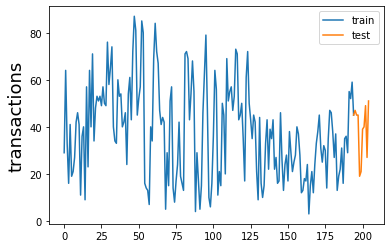

In [172]:
plt.plot(df_train.index,df_train['transactions'])
plt.plot(df_test.index,df_test['transactions'])
plt.ylabel('transactions',fontsize=18)
plt.legend(['train','test'])
plt.show()

# Model Leaderboard

In [173]:
lb = aml.leaderboard
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid__1_AutoML_20200723_092447_model_25,77.304,8.79227,77.304,6.23054,0.234238
XGBoost_grid__1_AutoML_20200723_092447_model_3,87.3999,9.34879,87.3999,8.53935,0.268271
XGBoost_grid__1_AutoML_20200723_092447_model_9,96.5416,9.82556,96.5416,7.16987,0.289363
XGBoost_grid__1_AutoML_20200723_092447_model_18,110.119,10.4937,110.119,8.82295,0.308536
StackedEnsemble_BestOfFamily_AutoML_20200723_092447,112.96,10.6283,112.96,9.30983,0.30056
XGBoost_grid__1_AutoML_20200723_092447_model_24,118.832,10.901,118.832,8.34355,0.308467
GBM_4_AutoML_20200723_092447,120.183,10.9628,120.183,9.06056,0.324098
DeepLearning_grid__3_AutoML_20200723_092447_model_1,121.973,11.0442,121.973,9.59945,0.327371
XGBoost_grid__1_AutoML_20200723_092447_model_1,122.651,11.0748,122.651,8.83295,0.323198
GBM_grid__1_AutoML_20200723_092447_model_7,125.406,11.1985,125.406,9.34496,0.328267


In [174]:
lb_as_df = h2o.as_list(lb)
best_mae = lb_as_df.iloc[0]['mae']
mape = best_mae/np.mean(dataset_y["transactions"])
print('MAE: %.3f' % best_mae)
print('MAPE: %.3f' % mape)

MAE: 6.231
MAPE: 0.174


#### Lag and windows

In [175]:
mask = df_processed.columns.str.contains('transactions')
df_processed[df_processed.columns[mask]].head(10)

,transactions,transactions_lag1,transactions_avg_window_length2,transactions_lag2,transactions_avg_window_length3,transactions_lag3,transactions_avg_window_length4,transactions_lag4,transactions_avg_window_length5,transactions_lag5,...,transactions_lag11,transactions_avg_window_length12,transactions_lag12,transactions_avg_window_length13,transactions_lag13,transactions_avg_window_length14,transactions_lag14,transactions_avg_window_length15,transactions_lag15,transactions_avg_window_length16
0,29.0,27.0,34.5,42.0,38.333333,46.0,39.00,41.0,33.4,11.0,...,64.0,36.333333,40.0,39.000000,71.0,38.642857,34.0,39.266667,48.0,40.1250
1,64.0,42.0,44.0,46.0,43.000000,41.0,35.00,11.0,35.2,36.0,...,40.0,40.000000,71.0,39.538462,34.0,40.142857,48.0,41.000000,53.0,41.6250
2,33.0,46.0,43.5,41.0,32.666667,11.0,33.50,36.0,34.8,40.0,...,71.0,39.333333,34.0,40.000000,48.0,40.928571,53.0,41.600000,51.0,42.3125
3,16.0,41.0,26.0,11.0,29.333333,36.0,32.00,40.0,27.4,9.0,...,34.0,39.500000,48.0,40.538462,53.0,41.285714,51.0,42.066667,53.0,42.5000
4,41.0,11.0,23.5,36.0,29.000000,40.0,24.00,9.0,30.6,57.0,...,48.0,40.500000,53.0,41.307692,51.0,42.142857,53.0,42.600000,49.0,43.5000
5,19.0,36.0,38.0,40.0,28.333333,9.0,35.50,57.0,33.0,23.0,...,53.0,43.833333,51.0,44.538462,53.0,44.857143,49.0,45.666667,57.0,45.9375
6,21.0,40.0,24.5,9.0,35.333333,57.0,32.25,23.0,38.6,64.0,...,51.0,45.250000,53.0,45.538462,49.0,46.357143,57.0,46.600000,50.0,46.7500
7,27.0,9.0,33.0,57.0,29.666667,23.0,38.25,64.0,38.6,40.0,...,53.0,46.000000,49.0,46.846154,57.0,47.071429,50.0,47.200000,49.0,49.0000
8,42.0,57.0,40.0,23.0,48.000000,64.0,46.00,40.0,51.0,71.0,...,49.0,50.000000,57.0,50.000000,50.0,49.928571,49.0,51.666667,76.0,52.0625
9,46.0,23.0,43.5,64.0,42.333333,40.0,49.50,71.0,46.4,34.0,...,57.0,49.416667,50.0,49.384615,49.0,51.285714,76.0,51.733333,58.0,52.5625


In [176]:
test_len = len(df_test)
lastrows = df.tail(test_len)
df_results = pd.DataFrame()
df_results['Date'] = lastrows.index
df_results['ground_truth'] = df_test['transactions'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.head(20)

,Date,ground_truth,predictions
0,2020-07-10,45.0,44.452816
1,2020-07-11,47.0,42.801090
2,2020-07-12,45.0,39.509476
3,2020-07-13,45.0,36.784641
4,2020-07-14,19.0,23.632668
5,2020-07-15,21.0,23.084997
6,2020-07-16,39.0,28.383970
7,2020-07-17,40.0,37.948975
8,2020-07-18,49.0,44.708546
9,2020-07-19,27.0,29.598221


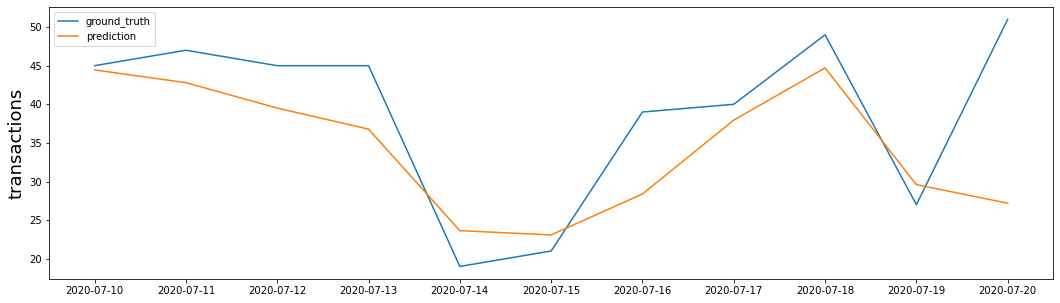

In [177]:
plt.figure(figsize=(18,5))
plt.plot(df_results['Date'],df_results['ground_truth'])
plt.plot(df_results['Date'],df_results['predictions'])
plt.ylabel('transactions',fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()

## Close h2o session

In [100]:
h2o.cluster().shutdown()

H2O session _sid_b82c closed.


In [21]:
len(df_test)

11